# Using LittleVGG for DeepCam

### Training Emotion Detector 

In [1]:
from __future__ import print_function
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
import os

num_classes = 7
img_rows, img_cols = 48, 48
batch_size = 16

# using fer2013 dataset with faces labelled with emotions
train_data_dir = './fer2013/train'
validation_data_dir = './fer2013/validation'

# augmenting data as dataset is not so large
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      shear_range=0.3,
      zoom_range=0.3,
      width_shift_range=0.4,
      height_shift_range=0.4,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        color_mode = 'grayscale',
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        color_mode = 'grayscale',
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

Using TensorFlow backend.


Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


##  Keras Imports

In [2]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.advanced_activations import ELU
from keras.layers.core import Activation, Flatten, Dropout, Dense

## Keras LittleVGG Model

In [3]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding = 'same', kernel_initializer="he_normal",
                 input_shape = (img_rows, img_cols, 1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding = "same", kernel_initializer="he_normal", 
                 input_shape = (img_rows, img_cols, 1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block #2: second CONV => RELU => CONV => RELU => POOL
# layer set
model.add(Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block #3: third CONV => RELU => CONV => RELU => POOL
# layer set
model.add(Conv2D(128, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block #4: third CONV => RELU => CONV => RELU => POOL
# layer set
model.add(Conv2D(256, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block #5: first set of FC => RELU layers
model.add(Flatten())
model.add(Dense(64, kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Block #6: second set of FC => RELU layers
model.add(Dense(64, kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Block #7: softmax classifier
model.add(Dense(num_classes, kernel_initializer="he_normal"))
model.add(Activation("softmax"))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
__________

## Training model

In [4]:
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Early Stopping Setup
checkpoint = ModelCheckpoint("./Trained Models/emotion_little_vgg_3.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, verbose = 1, min_delta = 0.0001)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint, reduce_lr]

# We use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics = ['accuracy'])

nb_validation_samples = 3589
epochs = 10
nb_train_samples=28709

history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size )

Epoch 1/10
1794/1794 [==============================] - 894s 498ms/step - loss: 2.0482 - acc: 0.2059 - val_loss: 1.7890 - val_acc: 0.2508

Epoch 00001: val_loss improved from inf to 1.78897, saving model to ./Trained Models/emotion_little_vgg_3.h5
Epoch 2/10
1794/1794 [==============================] - 991s 553ms/step - loss: 1.8039 - acc: 0.2473 - val_loss: 1.7812 - val_acc: 0.2648

Epoch 00002: val_loss improved from 1.78897 to 1.78115, saving model to ./Trained Models/emotion_little_vgg_3.h5
Epoch 3/10
1794/1794 [==============================] - 940s 524ms/step - loss: 1.7871 - acc: 0.2552 - val_loss: 1.7638 - val_acc: 0.2816

Epoch 00003: val_loss improved from 1.78115 to 1.76381, saving model to ./Trained Models/emotion_little_vgg_3.h5
Epoch 4/10
1794/1794 [==============================] - 1031s 575ms/step - loss: 1.7571 - acc: 0.2729 - val_loss: 1.7166 - val_acc: 0.3135

Epoch 00004: val_loss improved from 1.76381 to 1.71661, saving model to ./Trained Models/emotion_little_vgg_

Found 3589 images belonging to 7 classes.
Confusion Matrix
[[156   0  20  36 106 129  44]
 [ 29   0   0   4   0  18   4]
 [ 92   0  30  33 138 102 133]
 [ 24   0   2 728  69  23  33]
 [ 75   0  17 151 189  94 100]
 [ 43   0  18  50 249 217  17]
 [ 11   0  12  26  28   9 330]]
Classification Report
              precision    recall  f1-score   support

       Angry       0.36      0.32      0.34       491
     Disgust       0.00      0.00      0.00        55
        Fear       0.30      0.06      0.10       528
       Happy       0.71      0.83      0.76       879
     Neutral       0.24      0.30      0.27       626
         Sad       0.37      0.37      0.37       594
    Surprise       0.50      0.79      0.61       416

   micro avg       0.46      0.46      0.46      3589
   macro avg       0.35      0.38      0.35      3589
weighted avg       0.43      0.46      0.43      3589



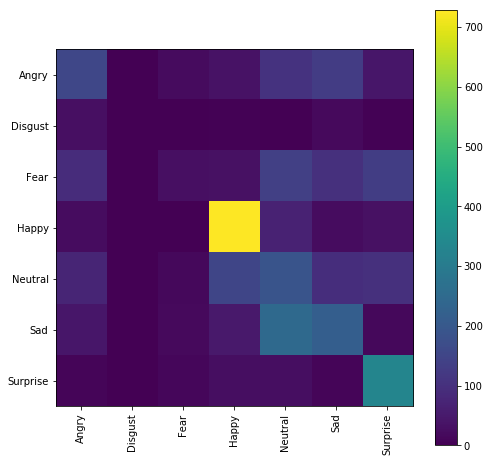

In [12]:
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

nb_train_samples = 28709
nb_validation_samples = 3589

# recreate our validation generator with shuffle = false
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        color_mode = 'grayscale',
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

This plot shows the uncertainity of the dataset and needs more data to train the model for better recognition. Though we acquired an accuracy of 46% with data augmentation. 

### Loading our saved model

In [7]:
from keras.models import load_model

classifier = load_model('./Trained Models/emotion_little_vgg_3.h5')

### Get our class labels

In [13]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        color_mode = 'grayscale',
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())
print(class_labels)

Found 3589 images belonging to 7 classes.
{0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Neutral', 5: 'Sad', 6: 'Surprise'}


### Webcam test



In [9]:
import cv2
import numpy as np
from time import sleep
from keras.preprocessing.image import img_to_array

face_classifier = cv2.CascadeClassifier('./Haarcascades/haarcascade_frontalface_default.xml')

def face_detector(img):
    # Convert image to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray, 1.3, 5)
    if faces is ():
        return (0,0,0,0), np.zeros((48,48), np.uint8), img
    
    for (x,y,w,h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = gray[y:y+h, x:x+w]

    try:
        roi_gray = cv2.resize(roi_gray, (48, 48), interpolation = cv2.INTER_AREA)
    except:
        return (x,w,y,h), np.zeros((48,48), np.uint8), img
    return (x,w,y,h), roi_gray, img

cap = cv2.VideoCapture(0)

while True:

    ret, frame = cap.read()
    rect, face, image = face_detector(frame)
    if np.sum([face]) != 0.0:
        roi = face.astype("float") / 255.0
        roi = img_to_array(roi)
        roi = np.expand_dims(roi, axis=0)

        # make a prediction on the ROI, then lookup the class
        preds = classifier.predict(roi)[0]
        label = class_labels[preds.argmax()]  
        label_position = (rect[0] + int((rect[1]/2)), rect[2] + 25)
        cv2.putText(image, label, label_position , cv2.FONT_HERSHEY_SIMPLEX,2, (0,255,0), 3)
    else:
        cv2.putText(image, "No Face Found", (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,2, (0,255,0), 3)
        
    cv2.imshow('All', image)
    if cv2.waitKey(1) == 13: #13 is the Enter Key
        break
        
cap.release()
cv2.destroyAllWindows()      

In [16]:
cap.release()
cv2.destroyAllWindows()      